In [1]:
import math
import torch
import torch.nn as nn

import fastai

from pytorch_tabnet.sparsemax import (
    Sparsemax,
    
)

from fastai.tabular.all import (
    LinBnDrop
)

from fastai.layers import (
    Identity

)

from Quick.cleaning.loading import (
    examine_dataset
)

from Quick.cleaning.utils import (
    get_file_path
)

from Quick.runners.deep import (
    run_deep_nn_experiment
)

from Quick.runners.residual import (
    run_residual_deep_nn_experiment
)

from Quick.runners.sk import (
    run_sk_experiment
)

from Quick.runners.torch import (
    run_torch_nn_experiment
)

from Quick.constants import *

In [2]:
data_path_1: str = './data/'
data_sets_1: list = [
    'Darknet_experiments_base.csv'
]

file_path_1: callable = get_file_path(data_path_1)
file_set_1: list = list(map(file_path_1, data_sets_1))
current_job: int = 0

dataset_1 = examine_dataset(0, file_set_1, data_sets_1)

Dataset 0/1: We now look at ./data/Darknet_experiments_base.csv


Loading Dataset: ./data/Darknet_experiments_base.csv
	To Dataset Cache: ./cache/Darknet_experiments_base.csv.pickle


        File:				./data/Darknet_experiments_base.csv  
        Job Number:			0
        Shape:				(117620, 64)
        Samples:			117620 
        Features:			64
    


In [3]:
dataset_1['Dataset'].head(100) # pandas dataframe

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Idle Mean,Idle Std,Idle Max,Idle Min,Traffic Type,Application Type
0,6,119384497,767,2027,90681,2448831,543,0,118.228162,224.244409,...,65535,65535,166,20,1.456330e+15,3.683488e+07,1.456330e+15,1.456330e+15,Tor,audio-streaming
1,6,119754701,1021,2537,171290,2922270,1460,0,167.766895,280.092409,...,65535,65535,292,20,1.456330e+15,3.558961e+07,1.456330e+15,1.456330e+15,Tor,audio-streaming
2,6,118908117,683,1662,77649,2001627,543,0,113.688141,221.086482,...,65535,65535,142,20,1.456330e+15,3.301057e+07,1.456330e+15,1.456330e+15,Tor,audio-streaming
3,6,739728,2,2,543,543,543,0,271.500000,383.958982,...,41180,65535,0,20,1.456330e+15,5.227810e+05,1.456330e+15,1.456330e+15,Tor,audio-streaming
4,6,149270,2,2,565,565,565,0,282.500000,399.515331,...,41180,65535,0,20,1.456330e+15,1.052330e+05,1.456330e+15,1.456330e+15,Tor,audio-streaming
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6,115426365,1108,2185,98188,2685198,1057,0,88.617329,226.052655,...,65535,65535,159,20,1.456340e+15,3.779664e+07,1.456340e+15,1.456340e+15,Tor,audio-streaming
96,6,118649517,875,1826,87821,2207469,1057,0,100.366857,218.139038,...,65535,65535,156,20,1.456340e+15,3.215990e+07,1.456340e+15,1.456340e+15,Tor,audio-streaming
97,6,116057783,1116,2238,99137,2738064,1460,0,88.832437,210.860857,...,65535,65535,175,20,1.456340e+15,4.012400e+07,1.456340e+15,1.456340e+15,Tor,audio-streaming
98,6,111719872,793,1645,74731,2013766,1057,0,94.238335,217.130895,...,65535,65535,130,20,1.456340e+15,2.806112e+07,1.456340e+15,1.456340e+15,Tor,audio-streaming


In [4]:
# we are going to select a random subset of our data

df = dataset_1['Dataset'].sample(frac=0.1, random_state=42)

In [5]:
dataset_1['Dataset'].shape

(117620, 64)

In [6]:
df.shape

(11762, 64)

In [7]:
results_sk = run_sk_experiment(df.drop(['Traffic Type'], axis=1), dataset_1['File'], 'Application Type')

Shape of Input Data: (11762, 63)
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       292
           1       0.78      0.90      0.84       670
           2       0.84      0.74      0.79       104
           3       0.71      0.54      0.61        28
           4       0.59      0.48      0.53       188
           5       0.93      0.93      0.93       966
           6       0.53      0.31      0.39        80
           7       0.89      0.67      0.76        24

    accuracy                           0.84      2352
   macro avg       0.77      0.68      0.72      2352
weighted avg       0.83      0.84      0.83      2352

	Accuracy: 0.8397108843537415



In [8]:
class Debug_Module(nn.Module):
    def __init__(self, name: str = 'Debug_Module', layers: list = None):
        super().__init__()

        self.name = name
        self.flag = True

        if layers is not None:
            self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.flag:
            print(f'{self.name} - {x.shape}')
            self.flag = False

        return x


In [9]:
def ghost_norm(X, groupsM, eps=1e-05):
    """
        X: Input Tensor with (M, C, F) dimensions
        groupsM: Number of groups for the mini-batch dimension
        eps: A small value to prevent division by zero

        (code taken from https://openreview.net/pdf/6ff818b5b1971be3a97d85efc2fc83ce24b9ef63.pdf)
    """

    # check to see if groupsM is a factor of M
    M, C, F = X.shape

    print(X.shape)

    # if M % groupsM != 0:
    #     raise ValueError("The number of groups must be a factor of the mini-batch size")

    # Split the mini-batch dimension into groups of smaller batches
    X = X.reshape(groupsM, -1, C, F)

    # Calculate statistics over dim(0) x dim(2) number of slices of dim(1) x dim(3) dimension each
    mean = X.mean([1, 3], keepdim=True)
    var = X.var([1, 3], unbiased=False, keepdim=True)

    # Normalize X
    X = (X - mean) / (torch.sqrt(var + eps))

    # Reshape into the initial tensor shape
    X = X.reshape(M, C, F)
    return X

class GhostNorm(nn.Module):
    def __init__(self, num_groups, eps=1e-05, affine=True):
        super().__init__()
        self.num_groups = num_groups
        self.eps = eps
        self.affine = affine
        self.batch_size = None
        self.running_mean = None
        self.running_var = None

        if self.affine:
            self.weight = nn.Parameter(torch.ones(1)) - eps/2
            self.bias = nn.Parameter(torch.zeros(1)) + eps/2

    def forward(self, X):
        B, C, F = X.shape

        if self.batch_size is None:
            self.batch_size = B


        print(X.shape)

        if X.shape[0] != self.batch_size:
        # if B % self.num_groups != 0:
            # we pad the input with random values taken from a normal distribution using the running mean and variance
            # to make sure that the number of groups is a factor of the batch size
            missing_B = self.batch_size - B
            X = torch.cat([X, torch.normal(self.running_mean, self.running_var ** .5, (missing_B, C, F))], dim=0)


        # Split the mini-batch dimension into groups of smaller batches
        X = X.reshape(self.num_groups, -1, C, F)

        # Calculate statistics over dim(0) x dim(2) number of slices of dim(1) x dim(3) dimension each
        mean = X.mean([1, 3], keepdim=True)
        var = X.var([1, 3], unbiased=False, keepdim=True)

        if self.running_mean is None:
            self.running_mean = torch.mean(mean)
            self.running_var = torch.mean(var)
        else:
            self.running_mean = 0.9 * self.running_mean + 0.1 * torch.mean(mean)
            self.running_var = 0.9 * self.running_var + 0.1 * torch.mean(var)

        # Normalize X
        X = (X - mean) / (torch.sqrt(var + self.eps))

        if B != X.shape[0]:
            X = X[:B]

        # Reshape into the initial tensor shape
        X = X.reshape(B, C, F)

        return self.weight * X + self.bias
        
        
        
        
        # return out

    def extra_repr(self):
        return '{num_features}, num_groups={num_groups}, eps={eps}'.format(**self.__dict__)

In [10]:
class DifferentiableMask(nn.Module):
    '''
        A differentiable mask that can be trained to mask out features in a feature vector

        parameters:
            input_size: the size of the input feature vector
            output_size: the size of the output feature vector

        input shape: (batch_size, input_size)
        output shape: (batch_size, output_size)
    '''

    def __init__(
        self,
        input_size: int = 32,
        output_size: int = 64,
        config: dict = None,
    ):
        super().__init__()

        self.mask_network = None
        self.activation = Sparsemax()

        if config is not None:
            if 'mask_network' in config:
                self.mask_network = config['mask_network']
            if 'activation' in config:
                self.activation = config['activation']
            
            
        if self.mask_network is None:
            # hidden_size = min(
            #     max(output_size, 4),
            #     input_size
            # )

            hidden_size = max(output_size, 4)

            self.mask_network = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.LeakyReLU(),
                nn.Linear(hidden_size, output_size),
                self.activation
            )

        else:
            self.mask_network = nn.Sequential(
                self.mask_network(input_size, output_size),
                self.activation
            )


    def forward(self, x):
        
        return self.mask_network(x)


In [26]:
def standard_wrapping_map(x: torch.Tensor) -> torch.Tensor:
    '''
        A function that wraps a tensor x in the standard wrapping map
            w: R -> S^1 : w(x) = (cos(2*pi*x), sin(2*pi*x)))

        parameters:
            x: the tensor to wrap

        returns:
            the wrapped tensor
    '''

    pi = torch.tensor(math.pi)

    wrapped = torch.cat((torch.cos(2*pi*x), torch.sin(2*pi*x)), dim=1)

    return wrapped

def exponential_fourier_map(x: torch.Tensor, dim: int = 2) -> torch.Tensor:
    '''
        A function that sends a tensor x to the fourier map
            f: R -> R^dim : f(x) = (sin(x*2^1), sin(x*2^2), ..., sin(x*2^dim))

        parameters:
            x: the tensor to send to the fourier map
            dim: the number of fourier features to generate

        returns:
            the fourier features of x
    '''

    fourier = torch.cat([torch.sin(x * 2**i) for i in range(1, dim + 1)], dim=1)

    return fourier


def generate_positional_encodings(
    encodings: int = 64,
    type: str = 'independent',
    config: dict = None,
    dim: int = 4,
    verbose: bool = False
) -> torch.Tensor:
    '''
        A function that generates positional encodings. These encodings can be
            in one of the following configurations:
                - independent: each encoding is a linearly independent unit vector
                - linear: each encoding is a step in the range [0, 1]
                - circular: each encoding is a step in the range [0, 1] that 
                                then has the standard wrapping map w applied to it

                                w: R -> S^1 : w(x) = (cos(2*pi*x), sin(2*pi*x)))    
        
                - fourier: each encoding is a step in the range [0, 1] that
                                then has the fourier map f applied to it

                                f: R -> R^dim : f(x) = (sin(x*2^1), (sin(x*2^2), ..., sin(x*2^dim))

    '''

    types = [
        'independent', 
        'linear', 
        'circular',
        'fourier_exp'
    ]

    positional_encodings = None

    if type not in types:
        raise ValueError(f"Positional mask type must be one of {types}")

    elif type == 'independent':
         # we produce a binary matrix of size (encodings, encodings) where the diagonal is all 1s and the rest are 0s
            #       this gives us a set of linearly independent vectors,

            positional_encodings = torch.eye(encodings, encodings)


    elif type == 'linear':
        # we produce a matrix of size (encodings, 1) of the form [[0], [1/(m-1)], [2/(m-1)], ..., [1]]
        #       this gives us a set of evenly spaced points on the line from 0 to 1, 

        positional_encodings = torch.arange(encodings).reshape(-1, 1) / (encodings - 1)

    elif type == 'circular':
        # we produce a matrix of size (masks, 1) of the form [[0], [1/m], [2/m], ..., [(m-1)/m]]
        #       then we pass them through the unit circle function to get the circular encoding
        #       this finally gives us a matrix of size (encodings, 2)

        domain_points = torch.arange(encodings).reshape(-1, 1) / encodings
        positional_encodings = standard_wrapping_map(domain_points)
        
    elif type == 'fourier_exp':
        # we produce a matrix of size (masks, 1) of the form [[0], [1/(m-1)], [2/(m-1)], ..., [1]]
        #       then we pass them through the exponential fourier map to get the fourier encoding
        #       this finally gives us a matrix of size (encodings, dim)

        domain_points = torch.arange(encodings).reshape(-1, 1) / (encodings - 1)
        positional_encodings = exponential_fourier_map(domain_points, dim=dim)


    if verbose:
        print(f"Generated {encodings} positional encodings of shape {positional_encodings.shape} with type {type}")

    return positional_encodings


In [12]:
torch.set_printoptions(sci_mode=False)

In [27]:
class SparsePositionalFilter(nn.Module):
    '''
        A sparse filter that takes a set of generated positional encodings and uses them to 
            find a set of sparse neighboorhoods of the input corresponding to the positional encodings.

        These sparse neighborhoods are then passed through a kernel to produce a single output feature. 
            If the kernel has more than one output, they are considered to be in separate channels.

        An output feature is calculated for each positional encoding, and the final output is a concatenation
            of all of these features.


        Algorithm: Sparse Convolution

            B  = batch size
            C  = input channels
            C' = output channels
            F  = input features
            F' = output features
            D  = positional encoding length

            Let X be an input tensor of shape (B, C, F)

            Let P be a set of positional encodings of shape (F', D)

            Let the kernel, K, be a MLP that defining a function K: R^(B * C * F) -> R^(B * C' * 1)

            for each i <= F':
                Let N_i = X * Sparsemax(MLP(P_i)) where * is the elementwise produce across the feature dimension

                Let O_i = K(N_i)

            Let O be the concatenation of all O_i along the feature dimension
                
        Then O is the output of the filter, and has shape (B, C', F')
    '''

    def __init__(
        self,
        features = 64, 
        channels = 1,
        filter_width = 1,
        num_encodings = 64,
        positional_type = 'independent',
        config: dict = None,
        verbose: bool = False
    ) -> None:
        super().__init__()

        self.features = features
        self.channels = channels
        self.filter_width = filter_width
        self.verbose = verbose

        self.positional_encodings = generate_positional_encodings(
            encodings = num_encodings, 
            type = positional_type
        )

        self.neighborhood = DifferentiableMask(
            input_size=self.positional_encodings.shape[1], 
            output_size=features,
            config=config, 
        )

        self.kernel = nn.Sequential(
            nn.Flatten(),
            nn.Linear(features * channels, self.filter_width, bias=False),
            nn.Unflatten(dim=1, unflattened_size=(self.filter_width, 1))
        )

        self.flag: bool = verbose
        self.local_flag: bool = verbose

    def forward(self, x):

        mask = self.neighborhood(self.positional_encodings)

        if self.flag:
            print(f"Input shape: {x.shape}")
            print(f"Positional Encodings shape: {self.positional_encodings.shape}")
            print(f"Poisitonal Encodings:\n {self.positional_encodings}")
            print(f"Mask shape: {mask.shape}")
            print(f"Mask:\n {mask}")

        outputs = []

        for i in range(self.positional_encodings.shape[0]):
            neighborhood = x * mask[i]

            outputs.append(
                self.kernel(neighborhood)
            )

            if self.local_flag:
                print(f"Neighborhood shape: {neighborhood.shape}")
                print(f"Neighborhood:\n {neighborhood}")
                print(f"Output shape: {outputs[-1].shape}")
                print(f"Output:\n {outputs[-1]}")

                self.local_flag = False

        output = torch.cat(outputs, dim=2)

        if self.flag:
            print(f"Final output shape: {output.shape}")
            print(f"Final output:\n {output}")

            self.flag = False

        return output

batch_size = 2
features = 6
channels = 5
filter_width = 3
encodings = 3


test_vals = torch.randn(batch_size, channels, features)

test_filter = SparsePositionalFilter(features=features, filter_width=filter_width, channels=channels, num_encodings=encodings, verbose=True)
print(f"Sparse filter with input shape {test_vals.shape}, encoding length {encodings}, and filter_width {filter_width} has {sum(p.numel() for p in test_filter.parameters())} parameters")
test_filter(test_vals)

Sparse filter with input shape torch.Size([2, 5, 6]), encoding length 3, and filter_width 3 has 156 parameters
Input shape: torch.Size([2, 5, 6])
Positional Encodings shape: torch.Size([3, 3])
Poisitonal Encodings:
 tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
Mask shape: torch.Size([3, 6])
Mask:
 tensor([[0.0706, 0.3704, 0.0040, 0.0242, 0.4899, 0.0409],
        [0.0600, 0.3425, 0.0000, 0.0000, 0.4650, 0.1324],
        [0.0579, 0.3843, 0.0140, 0.0000, 0.4560, 0.0877]],
       grad_fn=<SparsemaxFunctionBackward>)
Neighborhood shape: torch.Size([2, 5, 6])
Neighborhood:
 tensor([[[    -0.0516,     -0.1173,     -0.0000,     -0.0087,     -0.5894,
              -0.0223],
         [    -0.0092,      0.0128,     -0.0089,      0.0035,      0.4852,
               0.0423],
         [    -0.0689,     -0.2312,      0.0037,      0.0375,     -0.0824,
              -0.0253],
         [     0.0464,     -0.1389,     -0.0022,     -0.0363,      0.0436,
               0.0709],
       

tensor([[[ 0.0750,  0.0142,  0.0378],
         [ 0.0928,  0.0763,  0.0718],
         [ 0.0116,  0.0248,  0.0262]],

        [[-0.1583, -0.1467, -0.1637],
         [ 0.0327,  0.0220,  0.0383],
         [-0.2367, -0.2399, -0.2370]]], grad_fn=<CatBackward0>)

In [14]:
max([4, 5])

5

In [15]:
class PositionalEmbeddingKernel(nn.Module):
    '''
        Defines a kernel that takes an input and a positional encoding and produces 
            a single output feature for each i <= filter_width

        The kernel is defined as a 2-layer MLP that takes the input and an embedding 
            of the positional encoding as input and produces a single output feature. 


    '''
    def __init__(
        self,
        positional_encoding_shape: tuple,
        features: int,
        channels: int,
        filter_width: int,
    ) -> None:
        super().__init__()

        self.positional_encoding_shape = positional_encoding_shape
        self.features = features
        self.channels = channels
        self.filter_width = filter_width


        embedding_size = min(features, 10)

        self.embedding = nn.Sequential(
            nn.Linear(positional_encoding_shape[1], embedding_size, bias=False),
        )

        # hidden_size = math.floor((features * channels + filter_width)/2)

        self.before_kernel = nn.Flatten()

        self.kernel = nn.Sequential(
            nn.Linear(features * channels + embedding_size, self.filter_width, bias=False),
            nn.Unflatten(dim=1, unflattened_size=(self.filter_width, 1))
        )



    def forward(self, x, positional_encoding) -> torch.Tensor:

        pos = positional_encoding.reshape(1, -1)

        embedding = self.embedding(pos).repeat(x.shape[0], 1)

        x = self.before_kernel(x)

        # print(f"Input shape: {x.shape}")
        # print(f"Embedding shape: {embedding.shape}")

        output = self.kernel(torch.cat([x, embedding], dim=1))

        return output


encodings = 3
pos = generate_positional_encodings(encodings=encodings, type='independent')
print(f"Positional encodings shape: {pos.shape}")
print(f"Positional encodings:\n {pos}")
positional_encoding_shape = pos.shape
batch_size = 2
channels = 3
features = 4
filter_width = 5

test_vals = torch.randn(batch_size, channels, features)
test_vals

ker = PositionalEmbeddingKernel(
    positional_encoding_shape=positional_encoding_shape, 
    features=features, 
    channels=channels, 
    filter_width=filter_width
)

vals = ker(
    test_vals, 
    pos[0]
)

print(f"Kernel output shape: {vals.shape}")
print(f"Kernel output:\n {vals}")
# pos[0].reshape(1, -1).shape

Positional encodings shape: torch.Size([3, 3])
Positional encodings:
 tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
Kernel output shape: torch.Size([2, 5, 1])
Kernel output:
 tensor([[[ 0.4423],
         [ 0.6154],
         [ 0.3601],
         [ 0.1049],
         [ 0.4234]],

        [[-0.1557],
         [-0.1893],
         [ 0.2122],
         [-0.1670],
         [-0.4720]]], grad_fn=<ViewBackward0>)


In [16]:
class SparsePositionalEmbeddingFilter(nn.Module):
    '''
        A sparse filter that takes a set of generated positional encodings and uses them to 
            find a set of sparse neighboorhoods of the input corresponding to the positional encodings.

        These sparse neighborhoods are then passed through a kernel to produce a single output feature. 
            If the kernel has more than one output, they are considered to be in separate channels.

        An output feature is calculated for each positional encoding, and the final output is a concatenation
            of all of these features.


        Algorithm: Sparse Convolution

            B  = batch size
            C  = input channels
            C' = output channels
            F  = input features
            F' = output features
            D  = positional encoding length

            Let X be an input tensor of shape (B, C, F)

            Let P be a set of positional encodings of shape (F', D)

            Let the kernel, K, be a MLP that defining a function K: R^(B * C * F) x R^D -> R^(B * C' * 1)

            for each i <= F':
                Let N_i = X * Sparsemax(MLP(P_i)) where * is the elementwise produce across the feature dimension

                Let O_i = K(N_i, P_i)

            Let O be the concatenation of all O_i along the feature dimension
                
        Then O is the output of the filter, and has shape (B, C', F')
    '''

    def __init__(
        self,
        features = 64, 
        channels = 1,
        filter_width = 1,
        num_encodings = 64,
        positional_type = 'independent',
        positional_dim = 4,
        config: dict = None,
        verbose: bool = False
    ) -> None:
        super().__init__()

        self.features = features
        self.channels = channels
        self.filter_width = filter_width
        self.verbose = verbose


        self.positional_encodings = generate_positional_encodings(
            encodings = num_encodings, 
            type = positional_type,
            dim = positional_dim,
        )

        self.neighborhood = DifferentiableMask(
            input_size=self.positional_encodings.shape[1], 
            output_size=features,
            config=config, 
        )

        self.kernel = PositionalEmbeddingKernel(
            self.positional_encodings.shape,
            features,
            channels,
            filter_width,
        )

        self.flag: bool = verbose
        self.local_flag: bool = verbose

    def forward(self, x):

        mask = self.neighborhood(self.positional_encodings)

        if self.flag:
            print(f"Input shape: {x.shape}")
            print(f"features: {self.features}")
            print(f"channels: {self.channels}")
            print(f"filter_width: {self.filter_width}")
            print(f"num_encodings: {self.positional_encodings.shape[0]}")
            print(f"Positional Encodings shape: {self.positional_encodings.shape}")
            # print(f"Poisitonal Encodings:\n {self.positional_encodings}")
            print(f"Mask shape: {mask.shape}")
            # print(f"Mask:\n {mask}")

        outputs = []

        for i in range(self.positional_encodings.shape[0]):
            
            try:
                neighborhood = x * mask[i]
            except Exception as e:
                print(f'x shape: {x.shape}')
                print(f'mask shape: {mask.shape}')
                print(f'i: {i}')
                print(f'mask[i] shape: {mask[i].shape}')
                raise e

            outputs.append(
                self.kernel(neighborhood, self.positional_encodings[i])
            )

            if self.local_flag:
                print(f"Neighborhood shape: {neighborhood.shape}")
                # print(f"Neighborhood:\n {neighborhood}")
                print(f"Output shape: {outputs[-1].shape}")
                # print(f"Output:\n {outputs[-1]}")

                self.local_flag = False

        output = torch.cat(outputs, dim=2)

        if self.flag:
            print(f"Final output shape: {output.shape}")
            # print(f"Final output:\n {output}")

            self.flag = False

        return output

batch_size = 2
features = 6
channels = 5
filter_width = 3
encodings = 100


test_vals = torch.randn(batch_size, channels, features)

test_filter = SparsePositionalEmbeddingFilter(
    features=features, 
    filter_width=filter_width, 
    channels=channels, 
    num_encodings=encodings,
    # positional_type='circular',
    verbose=True
)
print(f"Sparse filter with input shape {test_vals.shape}, encoding length {encodings}, and filter_width {filter_width} has {sum(p.numel() for p in test_filter.parameters())} parameters")
test_filter(test_vals)

Sparse filter with input shape torch.Size([2, 5, 6]), encoding length 100, and filter_width 3 has 1356 parameters
Input shape: torch.Size([2, 5, 6])
features: 6
channels: 5
filter_width: 3
num_encodings: 100
Positional Encodings shape: torch.Size([100, 100])
Mask shape: torch.Size([100, 6])
Neighborhood shape: torch.Size([2, 5, 6])
Output shape: torch.Size([2, 3, 1])
Final output shape: torch.Size([2, 3, 100])


tensor([[[     0.0494,      0.0384,      0.0608,      0.0550,      0.0457,
               0.0523,      0.0429,      0.0574,      0.0376,      0.0472,
               0.0509,      0.0301,      0.0713,      0.0663,      0.0380,
               0.0639,      0.0271,      0.0501,      0.0404,      0.0427,
               0.0474,      0.0591,      0.0468,      0.0323,      0.0353,
               0.0625,      0.0418,      0.0499,      0.0498,      0.0411,
               0.0582,      0.0410,      0.0377,      0.0583,      0.0375,
               0.0445,      0.0593,      0.0368,      0.0466,      0.0707,
               0.0635,      0.0304,      0.0467,      0.0576,      0.0587,
               0.0460,      0.0413,      0.0442,      0.0445,      0.0459,
               0.0423,      0.0229,      0.0521,      0.0514,      0.0482,
               0.0321,      0.0364,      0.0461,      0.0515,      0.0665,
               0.0702,      0.0521,      0.0407,      0.0414,      0.0430,
               0.0657,   

In [17]:

pos = generate_positional_encodings(encodings=encodings, type='independent')
print(f"Positional encodings shape: {pos.shape}")
print(f"Positional encodings:\n {pos}")
positional_encoding_shape = pos.shape
batch_size = 2
channels = 3
features = 4
filter_width = 5

embedding_size = math.floor((positional_encoding_shape[1] + features)/2)
embedding_size = max([embedding_size, positional_encoding_shape[1]])

Positional encodings shape: torch.Size([100, 100])
Positional encodings:
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [18]:
class PositionalParamKernel(nn.Module):  # currently doesnt work
    def __init__(
        self,
        positional_encoding_shape: tuple,
        features: int,
        channels: int,
        filter_width: int,
    ) -> None:
        super().__init__()

        self.positional_encoding_shape = positional_encoding_shape
        self.features = features
        self.channels = channels
        self.filter_width = filter_width

        self.parameter_factory = nn.Sequential(
            Debug_Module('parameter factory input'),
            nn.Linear(positional_encoding_shape[1], features * channels * filter_width, bias=False),
            nn.LeakyReLU(),
            nn.Unflatten(dim=1, unflattened_size=(features * channels, filter_width))
        )


    def forward(self, x, positional_encoding):

        print(f"Input shape: {x.shape}")
        print(f"Positional encoding shape: {positional_encoding.shape}")
        print(f"Positional encoding:\n {positional_encoding}")

        pos = positional_encoding.reshape(1, -1).repeat(x.shape[0], 1)

        print(f"Positional encoding shape: {pos.shape}")

        weights = self.parameter_factory(pos)

        print(f"Weights shape: {weights.shape}")
        print(f"Weights:\n {weights}")

        x[0] = torch.zeros(x[0].shape)

        print(f"Input shape: {x.shape}")
        print(f"Input:\n {x}")

        output = torch.matmul(x, weights)

        print(f"Output shape: {output.shape}")
        print(f"Output:\n {output}")

        return output


pos = generate_positional_encodings(encodings=encodings, type='independent')
print(f"Positional encodings shape: {pos.shape}")
print(f"Positional encodings:\n {pos}")
positional_encoding_shape = pos.shape
batch_size = 2
channels = 3
features = 4
filter_width = 5

test_vals = torch.randn(batch_size, channels, features)
test_vals

ker = PositionalParamKernel(
    positional_encoding_shape=positional_encoding_shape, 
    features=features, 
    channels=channels, 
    filter_width=filter_width
)

ker(
    nn.Flatten()(test_vals), 
    pos[0]
).reshape(batch_size, -1)

# pos[0].reshape(1, -1).shape

Positional encodings shape: torch.Size([100, 100])
Positional encodings:
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
Input shape: torch.Size([2, 12])
Positional encoding shape: torch.Size([100])
Positional encoding:
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Positional encoding shape: torch.Size([2, 100])
parameter factory input - torch.Size([2, 100])
Weights shape: torch.Size([2

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1992, -0.0033,  0.1163,
          0.0035,  0.0943],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1992, -0.0033,  0.1163,
          0.0035,  0.0943]], grad_fn=<ReshapeAliasBackward0>)

In [19]:
class DifferenceMask(nn.Module):
    '''
        A differentiable mask that uses a difference vector as input to find a mask

        The difference vector is calculated for each feature in the input vector
            by subtracting the vector of duplicates of that feature 


        input shape: (batch_size, channels, features)
        output shape: (batch_size, channels, features)
    '''

    def __init__(
        self,
        features: int = 64,
        channels: int = 4,
        config: dict = None,
        verbose: bool = False,
    ):
        super().__init__()

        self.differentiable_mask = DifferentiableMask(input_size=features * channels, output_size=features, config=config)


    def forward(self, x, i):
        batch_size, channels, features = x.shape

        

        y = x[:, :, i].reshape(batch_size, channels, 1).repeat(1, 1, features)
        x_hat = x - y

        # we can now calculate the sparse neighborhood of each feature in x
        #   by passing x_hat through self.differentiable_mask

        x_mask = self.differentiable_mask(x_hat.reshape(batch_size, -1)).reshape(batch_size, 1, -1)

        return x_mask.repeat(1, channels, 1)


    # def forward(self, x):

    #     batch_size, channels, features = x.shape

    #     y = torch.cat(tuple((x[:, :, i].reshape(batch_size, channels, 1).repeat(1, 1, features) for i in range(features))), dim=0)
    #     x = x.repeat(features, 1, 1)

    #     x_hat = x - y

    #     # we can now calculate the sparse neighborhood of each feature in x
    #     #   by passing x_hat through self.differentiable_mask

    #     x_mask = self.differentiable_mask(x_hat.reshape(batch_size * features, -1)).reshape(batch_size, 1, features)

    #     return x_mask.repeat(1, channels, 1)
        



class PositionalMask(nn.Module):
    '''
        A differentiable mask that uses a positional encoding as input to find a mask
            
        This network does not take an input after configuration, but produces a positional encoding
            that can be used as input to a differential mask network
    '''

    types = ['independent', 'linear', 'circular']

    def __init__(
        self,
        masks: int = 32,
        size: int = 64,
        type: str = 'independent',
        config: dict = None,
        verbose: bool = False
    ):

        super().__init__()

        self.type = type
        self.masks = masks
        self.size = size
        self.verbose = verbose

        self.positional_encoding = None
        self.mask_input_shape = None

        if type not in self.types:
            raise ValueError(f"Positional mask type must be one of {self.types}")

        elif type == 'independent':
            # we produce a binary matrix of size (masks, masks) where the diagonal is all 1s and the rest are 0s
            #       this gives us a set of linearly independent vectors,
            #       meaning we train our mask to be a graph homomorphism taking unit vertices to the masking vertices 
            #       (i.e. the rows of the matrix)

            self.positional_encoding = torch.eye(masks, masks)
            self.mask_input_shape = (masks, masks)

        elif type == 'linear':
            # we produce a matrix of size (masks, 1) of the form [[0], [1/(m-1)], [2/(m-1)], ..., [1]]
            #       this gives us a set of points on the line from 0 to 1, 
            #       meaning we train our mask to be a path from 0 to 1

            self.positional_encoding = torch.arange(masks).reshape(-1, 1) / (masks - 1)
            self.mask_input_shape = (masks, 1)
            
        elif type == 'circular':
            # we produce a matrix of size (masks, 1) of the form [[0], [1/m], [2/m], ..., [(m-1)/m]]
            #       then we pass them through the unit circle function to get the circular encoding
            #       this finally gives us a matrix of size (masks, 2), 
            #       meaning we train our mask to be a loop parametrized by the unit circle

            pi = torch.tensor(math.pi)
            self.positional_encoding = torch.arange(masks).reshape(-1, 1) / masks
            self.positional_encoding = torch.cat((torch.cos(self.positional_encoding * 2 * pi), torch.sin(self.positional_encoding * 2 * pi)), dim=1)
            self.mask_input_shape = (masks, 2)


        self.differentiable_mask = DifferentiableMask(input_size=self.mask_input_shape[1], output_size=size, config=config)

        

    def forward(self, x):
        batch_size = x.shape[0]
        channels = x.shape[1]

        out: torch.Tensor = self.differentiable_mask(self.positional_encoding) 

        out = out.reshape(1, 1, -1)

        # we now duplicate the output for each batch and channel
        out = out.repeat(batch_size, channels, 1)


        return out




In [20]:
class SparseDifferenceFilter(nn.Module):
    '''
        A convolutional filter that trains a neighborhood function in each filter to determine the neighborhood of each feature
        input shape: (batch_size, channels, features)
        output shape: (batch_size, filter_width, features)
    
    '''
    def __init__(
        self, 
        features = 62, 
        channels = 1,
        filter_width = 1,
        config: dict = None,
        verbose: bool = False
    ):
        super().__init__()

        self.in_size = features
        self.channels = channels
        self.filter_width = filter_width

        self.neighborhood = DifferenceMask(features=features, channels=channels, config=config, verbose=verbose)

        self.kernel = nn.Sequential(
            nn.Linear(features * channels, self.filter_width, bias=False),
        )

        self.flag: bool = verbose
        self.local_flag: bool = verbose

        
    def forward(self, x):
        if self.flag:
            print('initial shape:\t\t\t', x.shape)

        # Each feature has a sparse neighborhood we can calculate using self.sparse_neighborhood
        # output = torch.zeros(x.shape[0], self.filter_width, self.in_size)
        output = torch.zeros(x.shape[0], self.filter_width, 0)
        
        for i in range(x.shape[2]):

            mask = self.neighborhood(x, i)

            if self.local_flag:
                print('mask size: \t\t\t', mask.shape)
                print('mask contents:')
                print(mask)


            # we extract the sparse neighborhood of x_i from x
            xm = x * mask

            if self.local_flag:
                print('masked input:\t\t\t', xm.shape)
                print('masked input contents:')
                print(xm)

            # finally, we perform the convolution using the kernel on the sparse neighborhood of x_i
            output_i = self.kernel(xm.reshape(x.shape[0], -1)).reshape(x.shape[0], -1, 1)

            if self.local_flag:
                print('output:\t\t\t\t', output.shape)
                print('output_i:\t\t\t', output_i.shape)
                print('output_i contents:')
                print(output_i)

                self.local_flag = False

            # to finish, we concatenate the output for this x_i to the output tensor
            output = torch.cat((output, output_i), dim=2)

        if self.flag:
            print("post-run - sparse filter:\t", output.shape)
            self.flag = False

        return output



batch_size = 2
features = 4
channels = 5
filter_width = 3


test_vals = torch.randn(batch_size, channels, features)

test_filter = SparseDifferenceFilter(features=features, filter_width=filter_width, channels=channels, verbose=True)
print(f"Sparse filter with input shape {test_vals.shape} and filter_width {filter_width} has {sum(p.numel() for p in test_filter.parameters())} parameters")
test_filter(test_vals)

Sparse filter with input shape torch.Size([2, 5, 4]) and filter_width 3 has 164 parameters
initial shape:			 torch.Size([2, 5, 4])
mask size: 			 torch.Size([2, 5, 4])
mask contents:
tensor([[[0.1855, 0.3087, 0.0204, 0.4855],
         [0.1855, 0.3087, 0.0204, 0.4855],
         [0.1855, 0.3087, 0.0204, 0.4855],
         [0.1855, 0.3087, 0.0204, 0.4855],
         [0.1855, 0.3087, 0.0204, 0.4855]],

        [[0.2736, 0.2071, 0.0000, 0.5194],
         [0.2736, 0.2071, 0.0000, 0.5194],
         [0.2736, 0.2071, 0.0000, 0.5194],
         [0.2736, 0.2071, 0.0000, 0.5194],
         [0.2736, 0.2071, 0.0000, 0.5194]]], grad_fn=<RepeatBackward0>)
masked input:			 torch.Size([2, 5, 4])
masked input contents:
tensor([[[ 0.0701, -0.0420, -0.0062,  0.5912],
         [-0.0142, -0.3608, -0.0025, -0.2937],
         [ 0.0796,  0.5579,  0.0175, -0.0936],
         [-0.0061,  0.0713, -0.0066,  0.0992],
         [ 0.1872, -0.1331, -0.0208,  0.0288]],

        [[-0.3343,  0.1059,  0.0000,  1.2233],
         [

tensor([[[ 0.1859,  0.1528,  0.1817,  0.1937],
         [-0.0540, -0.1169, -0.0664,  0.0492],
         [-0.1665, -0.1818, -0.1680, -0.0743]],

        [[ 0.2219,  0.1883,  0.0621,  0.0868],
         [ 0.1632,  0.1776,  0.1360,  0.1263],
         [-0.3086, -0.2566, -0.0648, -0.1428]]], grad_fn=<CatBackward0>)

In [22]:
class SparsePositionalEmbeddingConvolution(nn.Module):
    '''
        A convolutional layer that trains a neighborhood function in each filter to determine the neighborhood of each feature
        input shape: (batch_size, channels, features)
        output shape: (batch_size, filters * filter_width, features)
    '''
    def __init__(
        self, 
        features = 62, 
        channels = 1,
        filters = 1,
        filter_width = 1,
        num_encodings = 5,
        positional_type = 'independent',
        config: dict = None,
        verbose: bool = False
    ):
        super().__init__()

        self.in_size = features
        self.channels = channels
        self.num_filters = filters
        self.filter_width = filter_width

        self.filters = nn.ModuleList([
            SparsePositionalEmbeddingFilter(
                features=features, 
                channels=channels, 
                filter_width=filter_width,
                num_encodings=num_encodings,
                positional_type=positional_type,
                verbose=verbose
            )
            for _ in range(filters)
        ])

        self.flag: bool = verbose
        self.local_flag: bool = verbose

        
    def forward(self, x):
        if self.flag:
            print('initial shape:\t\t\t', x.shape)

        # We run each filter on the input in parallel
        output = torch.cat(tuple((filter(x) for filter in self.filters)), dim=1)


        if self.flag:
            print("post-run - sparse conv:\t", output.shape)
            self.flag = False

        return output




batch_size = 2
features = 4
channels = 2
filter_width = 3
filters = 2
num_encodings = 64


test_vals = torch.randn(batch_size, channels, features)

test_filter = SparsePositionalEmbeddingConvolution(
    features=features, 
    channels=channels, 
    filters=filters, 
    filter_width=filter_width, 
    num_encodings=num_encodings,
    verbose=True
)
print(f"Sparse filter with input shape {test_vals.shape} and filter_width {filter_width} has {sum(p.numel() for p in test_filter.parameters())} parameters")
test_filter(test_vals)

Sparse filter with input shape torch.Size([2, 2, 4]) and filter_width 3 has 1144 parameters
initial shape:			 torch.Size([2, 2, 4])
Input shape: torch.Size([2, 2, 4])
features: 4
channels: 2
filter_width: 3
num_encodings: 64
Positional Encodings shape: torch.Size([64, 64])
Mask shape: torch.Size([64, 4])
Neighborhood shape: torch.Size([2, 2, 4])
Output shape: torch.Size([2, 3, 1])
Final output shape: torch.Size([2, 3, 64])
Input shape: torch.Size([2, 2, 4])
features: 4
channels: 2
filter_width: 3
num_encodings: 64
Positional Encodings shape: torch.Size([64, 64])
Mask shape: torch.Size([64, 4])
Neighborhood shape: torch.Size([2, 2, 4])
Output shape: torch.Size([2, 3, 1])
Final output shape: torch.Size([2, 3, 64])
post-run - sparse conv:	 torch.Size([2, 6, 64])


tensor([[[     0.3711,      0.3718,      0.3552,      0.3874,      0.2998,
               0.3257,      0.3484,      0.3124,      0.3044,      0.4052,
               0.3141,      0.3665,      0.3224,      0.3585,      0.3229,
               0.4022,      0.3580,      0.3365,      0.3431,      0.3396,
               0.3626,      0.3299,      0.3533,      0.3567,      0.3376,
               0.3924,      0.3017,      0.3564,      0.3859,      0.3797,
               0.3327,      0.2912,      0.3890,      0.3190,      0.3266,
               0.3738,      0.3909,      0.3316,      0.2545,      0.3055,
               0.4079,      0.3096,      0.2973,      0.2824,      0.3531,
               0.3937,      0.3719,      0.3229,      0.3679,      0.3465,
               0.3093,      0.3473,      0.3350,      0.3157,      0.3189,
               0.3119,      0.3252,      0.3380,      0.3322,      0.3913,
               0.3788,      0.3254,      0.3481,      0.3439],
         [     0.3190,      0.3555,  

In [23]:
class SparsePositionalEmbeddingCNN(nn.Module):
    def __init__(self, input_features = 64, output_features = 8, channels: int = 1, device = 'cpu', verbose: bool = False, config: dict = {
        'conv_layers': [
            {
                'filters': 1,
                'filter_width': 5,
                'num_encodings': 64,
                'positional_type': 'independent',
                'pool_size': 32
            },
        ],

        'fc_layers': [
            100 for _ in range(3)
        ]
    }):
        super().__init__()

        self.input_features = input_features
        self.channels = channels
        self.output_features = output_features

        conv_layers = []
        pool_layers = []

        last_output_features = input_features

        if 'verbose' in config:
            verbose = config['verbose']

        for i, layer in enumerate(config['conv_layers']):

            features = last_output_features            

            conv_layers.append(
                SparsePositionalEmbeddingConvolution(
                    features=features, 
                    channels=channels,
                    filters=layer['filters'], 
                    filter_width=layer['filter_width'],
                    num_encodings=layer['num_encodings'],
                    positional_type=layer['positional_type'],
                    verbose=verbose
                )
            )

            channels = layer['filters'] * layer['filter_width']

            if 'pool_size' in layer:
                pool_layers.append(
                    nn.AdaptiveMaxPool1d(layer['pool_size'])
                )

                last_output_features = layer['pool_size']

            else:
                pool_layers.append(None)

                last_output_features = layer['num_encodings']

        layers = []

        for i, layer in enumerate(conv_layers):
            channels = layer.num_filters * layer.filter_width
            layers.append(layer)

            layers.append(
                nn.LeakyReLU()
            )

            layers.append(
                nn.GroupNorm(channels, channels)
            )

            if pool_layers[i] is not None:
                layers.append(pool_layers[i])


        head_input_size = conv_layers[-1].num_filters * conv_layers[-1].filter_width * last_output_features

        fc_layers = []
        if 'fc_layers' in config and len(config['fc_layers']) > 0:
            for i, layer in enumerate(config['fc_layers']):
                size = head_input_size if i == 0 else config['fc_layers'][i-1]

                fc_layers.extend([
                    nn.Linear(size, layer),
                    nn.ReLU()
                ])

            fc_layers.append(
                nn.Linear(config['fc_layers'][-1], output_features)
            )
        
        else:
            fc_layers.append(
                nn.Linear(head_input_size, output_features)
            )

        self.head = nn.Sequential(
            *layers,
            Debug_Module('pre-flatten'),
            nn.Flatten(),
            Debug_Module('post-flatten'),
            *fc_layers
            # nn.Linear(conv_layers[-1].num_filters * conv_layers[-1].filter_width * last_output_features, output_features)
        )

        self.flag: bool = True


    def forward(self, x):
        if self.flag:
            print('Pre-run: simple_model -', x.shape)

        if len(x.shape) == 2:
            x = x.reshape(x.shape[0], 1, -1)

            if self.flag:
                print("reshaped: simple_model -", x.shape)

        x = self.head(x)

        if self.flag:
            print('Post-run: simple_model -', x.shape)
            self.flag = False

        # raise Exception('stop')
        return x


In [24]:
    


batch_size = 64
features = 64
channels = 1
filter_width = 3
filters = 2
num_encodings = 3

if channels == 1:
    test_vals = torch.randn(batch_size, features)
else:
    test_vals = torch.randn(batch_size, channels, features)


test_cnn = SparsePositionalEmbeddingCNN(
    input_features=features,
    channels=channels,
    output_features=8,
    config = {
        'conv_layers': [
            # {
            #     'filters': 3,
            #     'filter_width': 2,
            #     'num_encodings': 64,
            #     'positional_type': 'independent',
            #     'pool_size': 32
            # },
            {
                'filters': 1,
                'filter_width': 5,
                'num_encodings': 128,
                'positional_type': 'independent',
                # 'positional_type': 'linear',
                'pool_size': 64
            }
        ],
        # 'fc_layers': [
        #     100 for _ in range(3)
        # ]
    },
    verbose=True
)

print(f"Sparse CNN with input shape {test_vals.shape} and filter_width {filter_width} has {sum(p.numel() for p in test_cnn.parameters())} parameters")

test_cnn(test_vals)

Sparse CNN with input shape torch.Size([64, 64]) and filter_width 3 has 16644 parameters
Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
initial shape:			 torch.Size([64, 1, 64])
Input shape: torch.Size([64, 1, 64])
features: 64
channels: 1
filter_width: 5
num_encodings: 128
Positional Encodings shape: torch.Size([128, 128])
Mask shape: torch.Size([128, 64])
Neighborhood shape: torch.Size([64, 1, 64])
Output shape: torch.Size([64, 5, 1])
Final output shape: torch.Size([64, 5, 128])
post-run - sparse conv:	 torch.Size([64, 5, 128])
pre-flatten - torch.Size([64, 5, 64])
post-flatten - torch.Size([64, 320])
Post-run: simple_model - torch.Size([64, 8])


tensor([[     0.7014,      0.1080,     -0.2667,     -0.2373,      0.4558,
              0.0396,      0.1340,     -1.2105],
        [     0.2512,      0.4574,     -0.2484,     -0.0131,      0.2593,
              0.0126,      0.1251,     -0.3531],
        [     0.6231,      0.6039,     -0.0480,     -0.3643,      0.5486,
             -0.0894,     -0.1704,     -0.1428],
        [     1.1560,      0.5458,     -0.4810,     -0.6286,      1.1312,
              0.3003,     -0.0198,     -0.5817],
        [    -0.1407,     -0.5389,     -0.4236,     -0.5794,      0.6659,
              0.3087,      0.3232,      0.0565],
        [     0.1072,      0.4473,     -0.0213,     -0.2203,     -0.2409,
             -0.3698,     -0.4129,     -0.1938],
        [     0.9571,      0.0014,     -0.4154,     -0.6664,      0.2181,
              0.5853,     -0.0781,     -0.7460],
        [     1.2122,     -0.0694,     -0.2775,     -0.5098,      0.4043,
              0.3221,     -0.7647,     -0.6312],
        [    -0.

Shape of Input Data: (11762, 63)
Parameters in the model: 32314


Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
pre-flatten - torch.Size([64, 2, 32])
post-flatten - torch.Size([64, 64])
Post-run: simple_model - torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.727621,1.495244,0.509779,0.169671,0.672756,0.248640,0.136752,0.118338,0.169671,00:07
1,1.332157,1.259844,0.621173,0.262772,0.701277,0.440966,0.250933,0.252714,0.262772,00:06
2,1.223557,1.178641,0.630527,0.273970,0.750137,0.456296,0.266186,0.379006,0.273970,00:06
3,1.137938,1.114273,0.634354,0.276078,0.782860,0.464031,0.261318,0.310351,0.276078,00:09
4,1.089848,1.080347,0.628401,0.273745,0.799991,0.454056,0.262045,0.284657,0.273745,00:09
5,1.034944,1.035277,0.662840,0.347945,0.815322,0.510322,0.360031,0.429199,0.347945,00:08
6,1.036159,1.000930,0.671769,0.357153,0.822328,0.524649,0.371435,0.420713,0.357153,00:09
7,1.004992,0.962497,0.690476,0.389500,0.822640,0.554297,0.397911,0.432547,0.389500,00:06
8,0.956996,0.925858,0.716837,0.400476,0.835790,0.595075,0.409086,0.447478,0.400476,00:08
9,0.944526,0.895082,0.707483,0.403139,0.842095,0.581314,0.405026,0.431299,0.403139,00:09


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


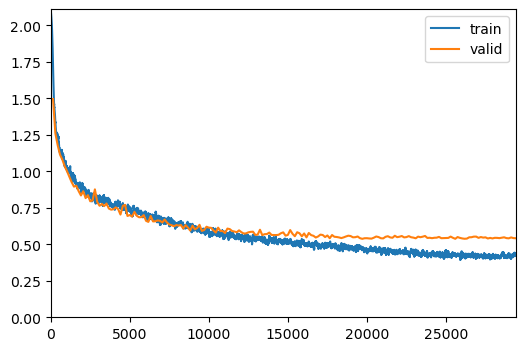

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

loss: 0.5414401888847351, accuracy:  83.21%


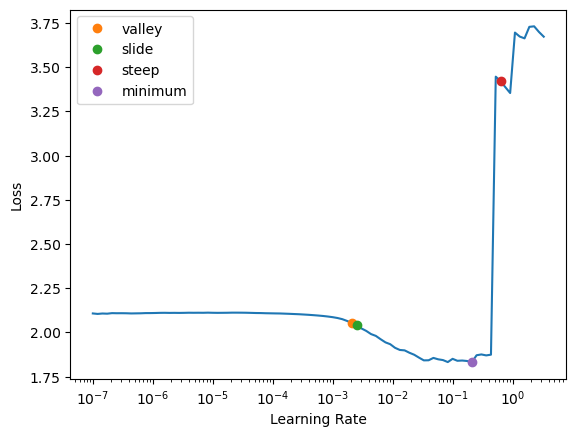

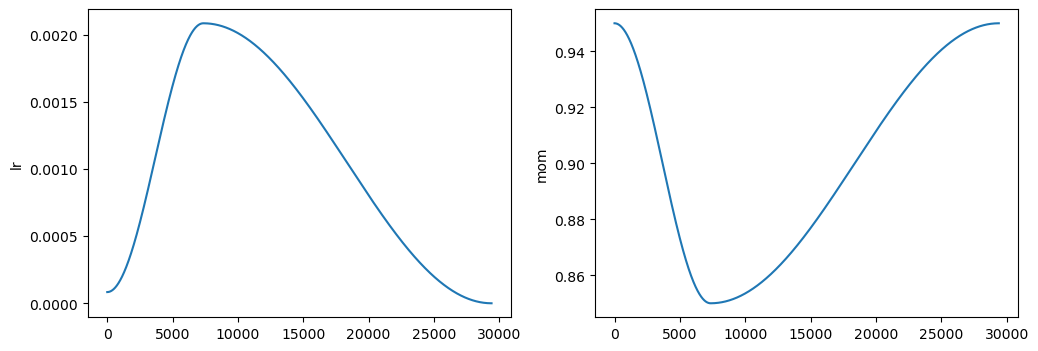

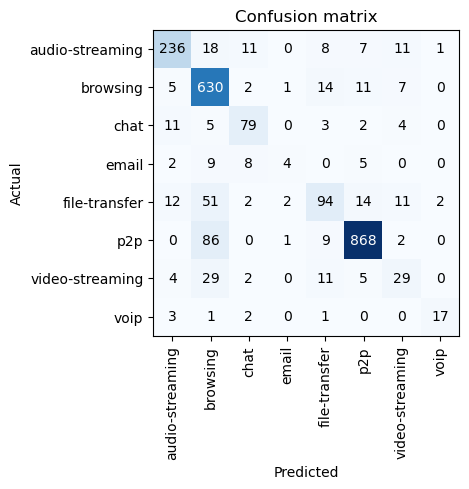

In [29]:
results_sparse_pe_cnn_1 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    SparsePositionalEmbeddingCNN, 
    config = {
        'conv_layers': [
            {
                'filters': 1,
                'filter_width': 2,
                'num_encodings': 64,
                'positional_type': 'fourier_exp',
                'pool_size': 32
            },
        ],
        'fc_layers': [
            100 for _ in range(3)
        ]
    },
    epochs=200
)

Shape of Input Data: (11762, 63)
Parameters in the model: 5326


Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
pre-flatten - torch.Size([64, 2, 32])
post-flatten - torch.Size([64, 64])
Post-run: simple_model - torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.859006,1.626156,0.498299,0.227818,0.612821,0.268410,0.233146,0.270856,0.227818,00:04
1,1.403497,1.328903,0.582483,0.250476,0.707630,0.388379,0.238995,0.263098,0.250476,00:04
2,1.264083,1.205426,0.624575,0.272761,0.741402,0.446979,0.263861,0.329769,0.272761,00:04
3,1.176446,1.129074,0.647109,0.329336,0.770102,0.484999,0.336980,0.396320,0.329336,00:04
4,1.132964,1.084854,0.673895,0.366321,0.788389,0.528014,0.362961,0.399451,0.366321,00:04
5,1.110952,1.077238,0.672194,0.366019,0.794966,0.525929,0.361748,0.366633,0.366019,00:04
6,1.067449,1.027531,0.675170,0.373744,0.810683,0.530243,0.373525,0.470338,0.373744,00:03
7,1.043237,1.023038,0.671769,0.366333,0.822167,0.524990,0.360468,0.362555,0.366333,00:03
8,1.008170,0.973093,0.682823,0.379736,0.840270,0.541796,0.385583,0.471025,0.379736,00:03
9,0.986397,0.956228,0.683248,0.373644,0.844062,0.542181,0.374882,0.495847,0.373644,00:03


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


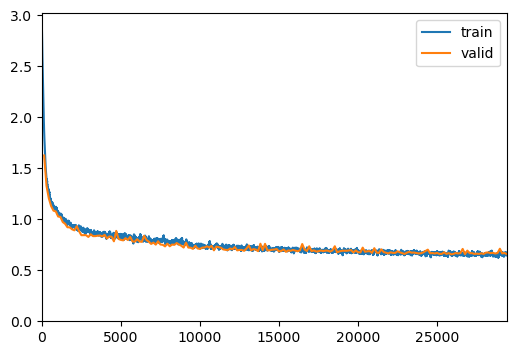

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

loss: 0.6589380502700806, accuracy:  79.08%


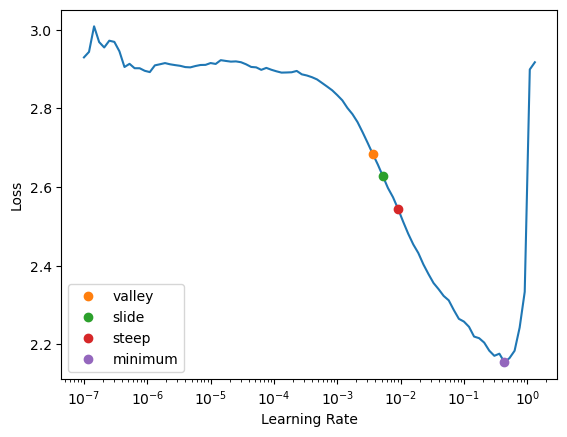

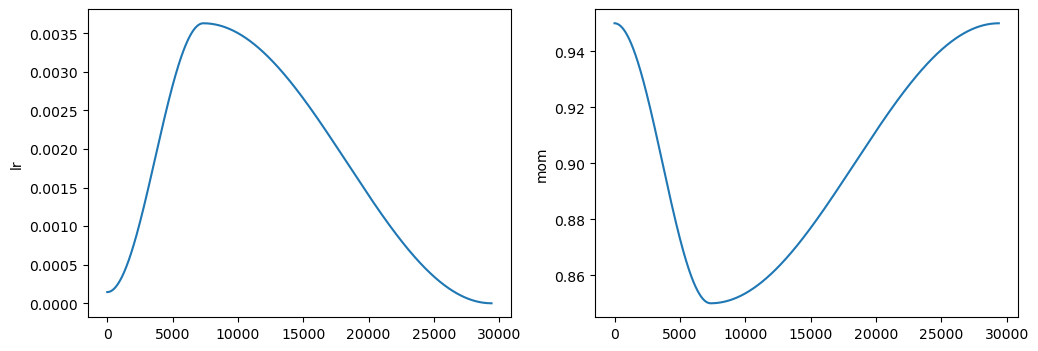

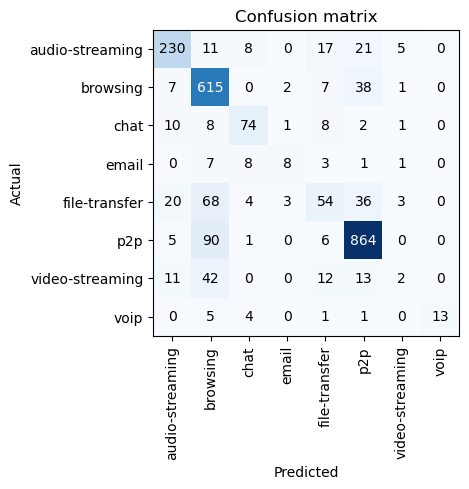

In [30]:
results_sparse_pe_cnn_2 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    SparsePositionalEmbeddingCNN, 
    config = {
        'conv_layers': [
            {
                'filters': 1,
                'filter_width': 2,
                'num_encodings': 64,
                'positional_type': 'fourier_exp',
                'pool_size': 32
            },
        ],
        # 'fc_layers': [
        #     100 for _ in range(3)
        # ]
    },
    epochs=200
)

Shape of Input Data: (11762, 63)
Parameters in the model: 7318


Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
pre-flatten - torch.Size([64, 8, 32])
post-flatten - torch.Size([64, 256])
Post-run: simple_model - torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.580839,1.451241,0.433248,0.138303,0.688511,0.099878,0.104389,0.211509,0.138303,00:04
1,1.364586,1.325034,0.598214,0.248637,0.730254,0.405475,0.238901,0.247780,0.248637,00:04
2,1.265823,1.234691,0.630527,0.280010,0.764100,0.456774,0.277369,0.366945,0.280010,00:04
3,1.201108,1.172525,0.637330,0.285397,0.783773,0.469754,0.274798,0.351315,0.285397,00:04
4,1.160589,1.126533,0.638605,0.286966,0.800491,0.471648,0.277907,0.333102,0.286966,00:04
5,1.088669,1.085116,0.652636,0.297136,0.806589,0.493109,0.293879,0.334246,0.297136,00:04
6,1.082853,1.047606,0.681122,0.372267,0.813679,0.539624,0.382695,0.427629,0.372267,00:04
7,1.028442,1.017321,0.681122,0.386100,0.818708,0.539763,0.399855,0.467805,0.386100,00:04
8,1.011574,0.995476,0.685799,0.391759,0.820582,0.547270,0.403902,0.463571,0.391759,00:04
9,0.976815,0.949132,0.701531,0.402404,0.836419,0.571479,0.415961,0.487254,0.402404,00:04


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


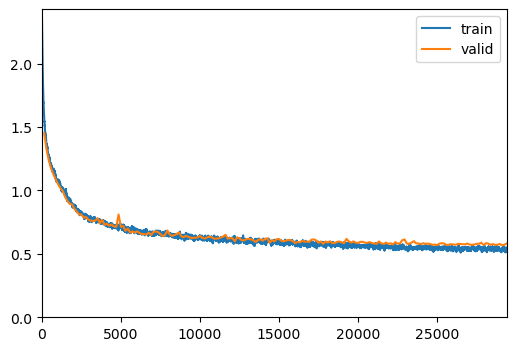

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

loss: 0.5826647281646729, accuracy:  80.61%


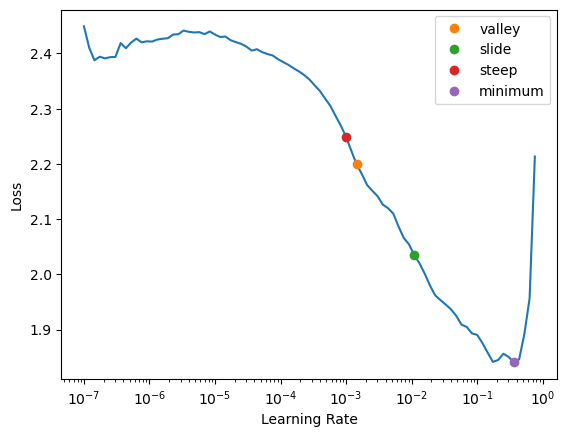

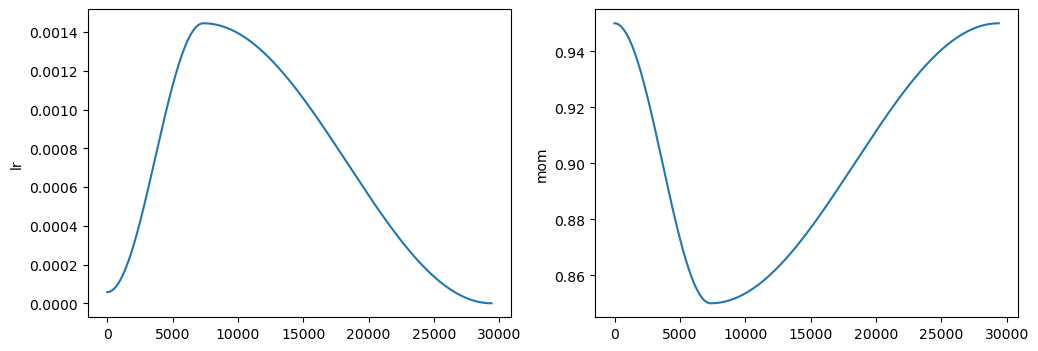

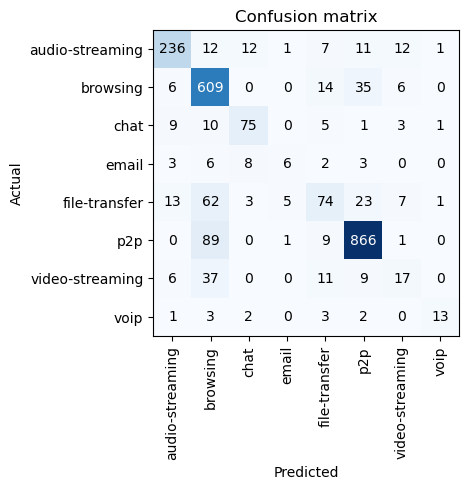

In [31]:
results_sparse_pe_cnn_3 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    SparsePositionalEmbeddingCNN, 
    config = {
        'conv_layers': [
            {
                'filters': 1,
                'filter_width': 8,
                'num_encodings': 64,
                'positional_type': 'fourier_exp',
                'pool_size': 32
            },
        ],
        # 'fc_layers': [
        #     100 for _ in range(3)
        # ]
    },
    epochs=200
)

Shape of Input Data: (11762, 63)
Parameters in the model: 51970


Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
pre-flatten - torch.Size([64, 8, 32])
post-flatten - torch.Size([64, 256])
Post-run: simple_model - torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.816748,1.675912,0.410714,0.125000,0.673711,0.000000,0.072785,0.051339,0.125000,00:07
1,1.540111,1.480744,0.410714,0.125000,0.692116,0.000000,0.072785,0.051339,0.125000,00:08
2,1.409273,1.357448,0.476616,0.183794,0.707565,0.202026,0.168986,0.199863,0.183794,00:08
3,1.303732,1.247906,0.624150,0.270789,0.729212,0.448192,0.250852,0.236049,0.270789,00:07
4,1.212645,1.174180,0.639456,0.283658,0.769465,0.472705,0.270214,0.364370,0.283658,00:08
5,1.151863,1.115517,0.636480,0.283746,0.788913,0.467609,0.274342,0.364862,0.283746,00:07
6,1.125025,1.074880,0.651786,0.292788,0.807864,0.494556,0.279077,0.329458,0.292788,00:08
7,1.089302,1.038625,0.656037,0.306648,0.809890,0.500168,0.306545,0.405502,0.306648,00:07
8,1.036785,0.994816,0.686224,0.384478,0.822410,0.548694,0.389715,0.441235,0.384478,00:07
9,0.999131,0.960505,0.693027,0.387733,0.829347,0.558346,0.392775,0.437263,0.387733,00:07


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


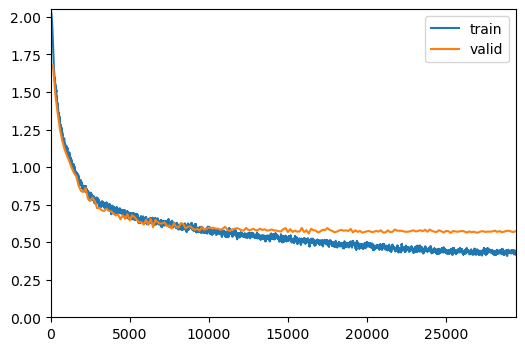

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

loss: 0.5731357932090759, accuracy:  82.40%


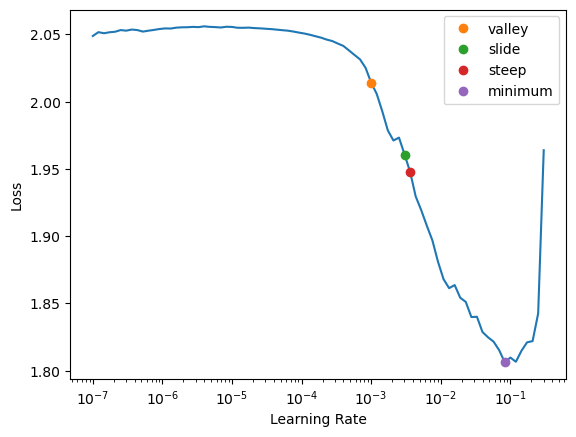

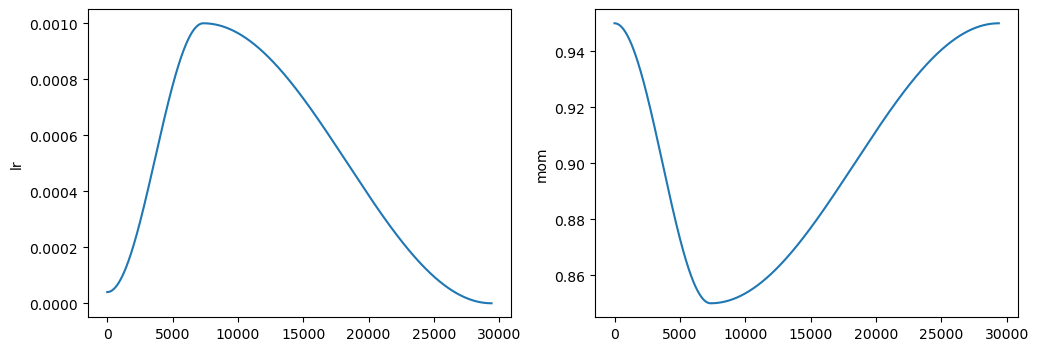

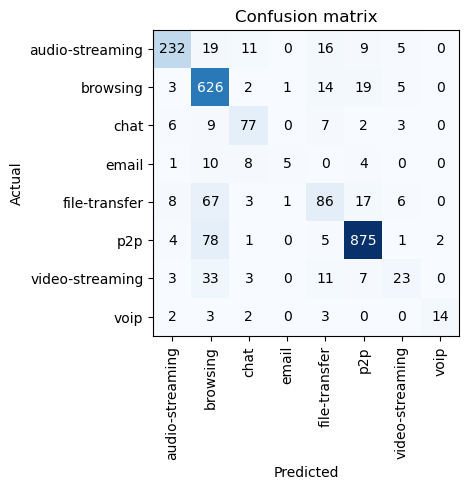

In [32]:
results_sparse_pe_cnn_4 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    SparsePositionalEmbeddingCNN, 
    config = {
        'conv_layers': [
            {
                'filters': 1,
                'filter_width': 8,
                'num_encodings': 64,
                'positional_type': 'fourier_exp',
                'pool_size': 32
            },
        ],
        'fc_layers': [
            100 for _ in range(3)
        ]
    },
    epochs=200
)

Shape of Input Data: (11762, 63)
Parameters in the model: 56490


Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
pre-flatten - torch.Size([64, 8, 32])
post-flatten - torch.Size([64, 256])
Post-run: simple_model - torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.900962,1.756700,0.410714,0.125000,0.674616,0.000000,0.072785,0.051339,0.125000,00:10
1,1.541436,1.461952,0.411139,0.125244,0.706628,0.012196,0.073644,0.079261,0.125244,00:10
2,1.387445,1.326561,0.521684,0.176724,0.715813,0.269999,0.144103,0.122354,0.176724,00:10
3,1.297930,1.228624,0.622874,0.267198,0.741952,0.443689,0.256222,0.258479,0.267198,00:10
4,1.208340,1.166831,0.631803,0.274033,0.766277,0.460260,0.253426,0.237889,0.274033,00:10
5,1.138908,1.106390,0.654337,0.294295,0.791615,0.497341,0.281931,0.346071,0.294295,00:10
6,1.108602,1.064853,0.657313,0.296344,0.800934,0.504687,0.282691,0.337745,0.296344,00:11
7,1.057387,1.026011,0.659864,0.297484,0.811886,0.507251,0.284349,0.315437,0.297484,00:10
8,1.022596,1.003660,0.663690,0.306252,0.812391,0.515680,0.295197,0.300104,0.306252,00:10
9,0.979860,1.000700,0.666667,0.372617,0.824437,0.522473,0.386632,0.437465,0.372617,00:10


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


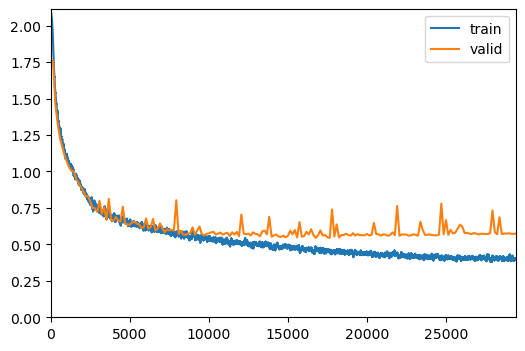

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

loss: 0.5733852386474609, accuracy:  82.91%


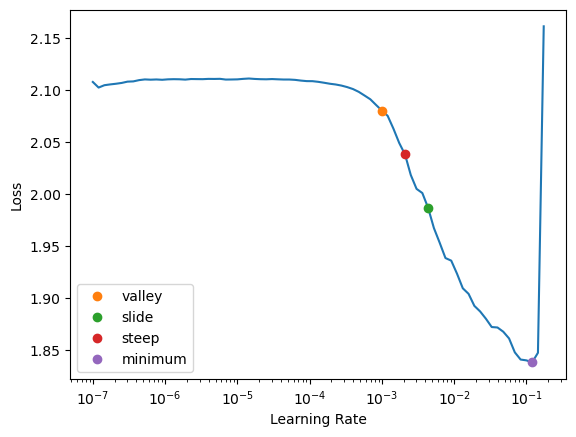

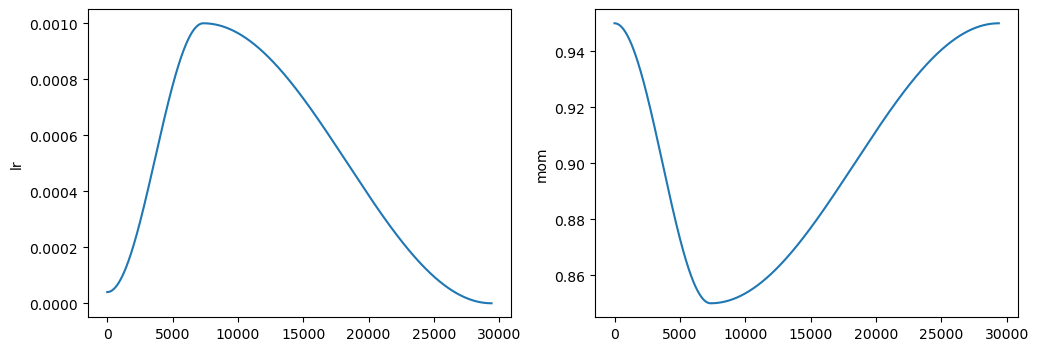

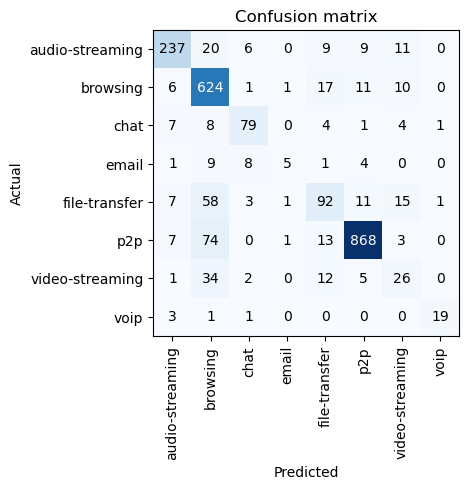

In [33]:
results_sparse_pe_cnn_5 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    SparsePositionalEmbeddingCNN, 
    config = {
        'conv_layers': [
            {
                'filters': 2,
                'filter_width': 4,
                'num_encodings': 64,
                'positional_type': 'fourier_exp',
                'pool_size': 32
            },
        ],
        'fc_layers': [
            100 for _ in range(3)
        ]
    },
    epochs=200
)

Shape of Input Data: (11762, 63)
Parameters in the model: 56490


Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
pre-flatten - torch.Size([64, 8, 32])
post-flatten - torch.Size([64, 256])
Post-run: simple_model - torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,2.035547,1.998556,0.410714,0.125000,0.638427,0.015851,0.072917,0.051471,0.125000,00:15
1,1.840398,1.741910,0.410714,0.125000,0.696206,0.000000,0.072785,0.051339,0.125000,00:14
2,1.593631,1.529883,0.410714,0.125000,0.707050,0.000000,0.072785,0.051339,0.125000,00:14
3,1.476187,1.435289,0.420068,0.130019,0.712463,0.062203,0.088101,0.074447,0.130019,00:14
4,1.391940,1.346235,0.519983,0.175349,0.721206,0.266485,0.142642,0.121427,0.175349,00:14
5,1.318541,1.269232,0.612245,0.260939,0.728536,0.426789,0.250556,0.254386,0.260939,00:14
6,1.231861,1.200672,0.628827,0.272669,0.757703,0.455285,0.253180,0.239015,0.272669,00:14
7,1.160979,1.143269,0.627976,0.271693,0.775422,0.455141,0.250118,0.234124,0.271693,00:14
8,1.115940,1.094388,0.639881,0.285823,0.793124,0.473711,0.274454,0.355575,0.285823,00:14
9,1.064174,1.052925,0.651361,0.295072,0.813044,0.500250,0.281107,0.345400,0.295072,00:14


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


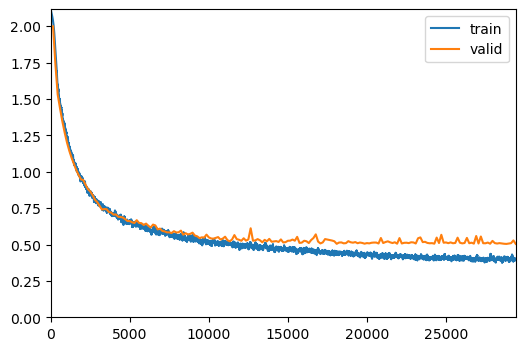

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

loss: 0.5041998028755188, accuracy:  83.42%


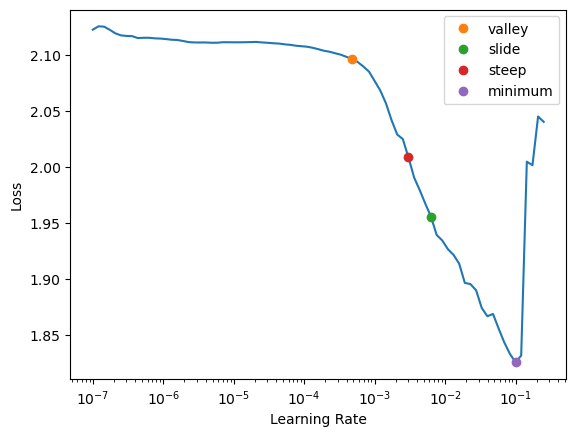

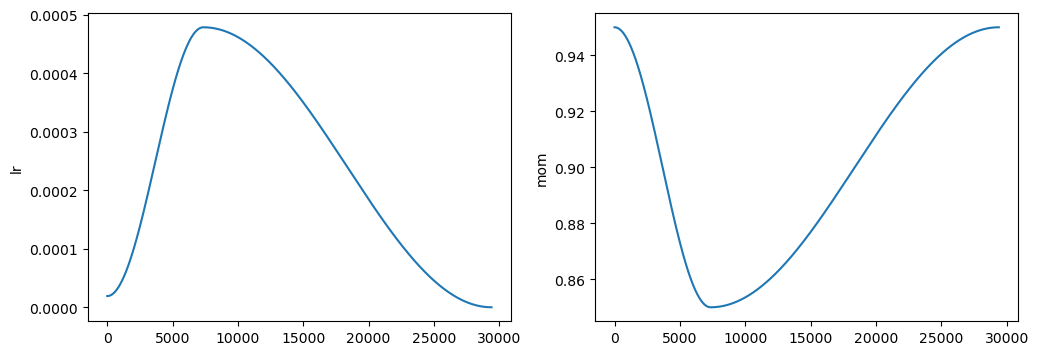

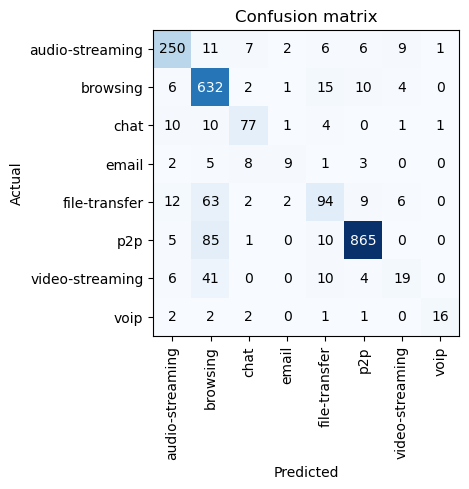

In [34]:
results_sparse_pe_cnn_6 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    SparsePositionalEmbeddingCNN, 
    config = {
        'conv_layers': [
            {
                'filters': 2,
                'filter_width': 4,
                'num_encodings': 128,
                'positional_type': 'fourier_exp',
                'pool_size': 32
            },
        ],
        'fc_layers': [
            100 for _ in range(3)
        ]
    },
    epochs=200
)

Shape of Input Data: (11762, 63)
Parameters in the model: 56490


Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
pre-flatten - torch.Size([64, 8, 32])
post-flatten - torch.Size([64, 256])
Post-run: simple_model - torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.950823,1.846849,0.410714,0.125000,0.663752,0.000000,0.072785,0.051339,0.125000,00:23
1,1.585756,1.493765,0.410714,0.125000,0.702131,0.000000,0.072785,0.051339,0.125000,00:23
2,1.426774,1.367742,0.514881,0.172881,0.712458,0.257132,0.140167,0.119559,0.172881,00:23
3,1.317988,1.264976,0.579507,0.230684,0.728387,0.371683,0.222822,0.251989,0.230684,00:23
4,1.240049,1.192951,0.628827,0.271926,0.761330,0.455983,0.251275,0.236180,0.271926,00:23
5,1.177607,1.143827,0.649660,0.294212,0.788726,0.493570,0.279965,0.352910,0.294212,00:23
6,1.119797,1.090673,0.643707,0.287757,0.798493,0.479505,0.276466,0.341645,0.287757,00:23
7,1.080088,1.051872,0.655612,0.295790,0.804320,0.500509,0.282917,0.318180,0.295790,00:23
8,1.045494,1.013527,0.681548,0.315644,0.813097,0.549372,0.302774,0.317133,0.315644,00:23
9,0.984392,0.977309,0.681973,0.310282,0.818589,0.547042,0.292117,0.310692,0.310282,00:23


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


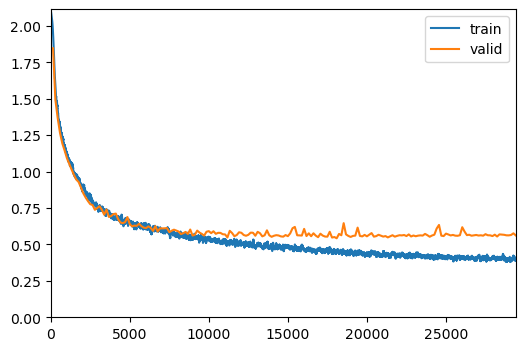

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

loss: 0.5622671842575073, accuracy:  83.25%


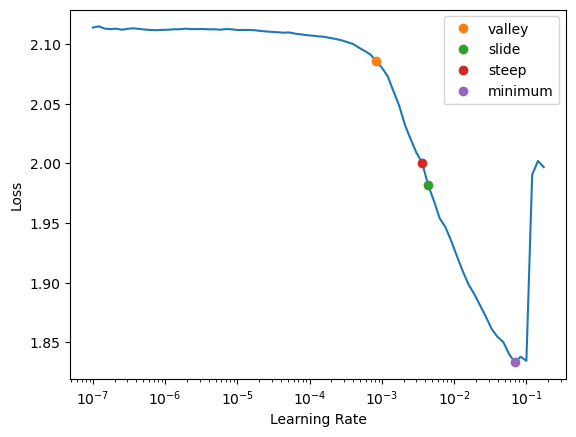

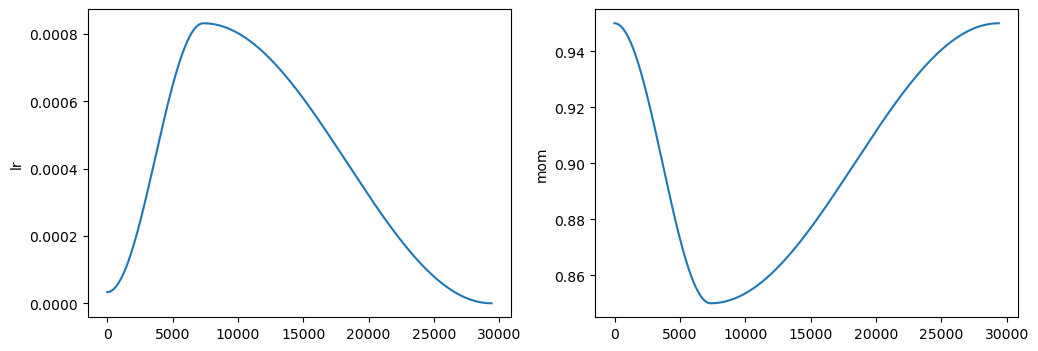

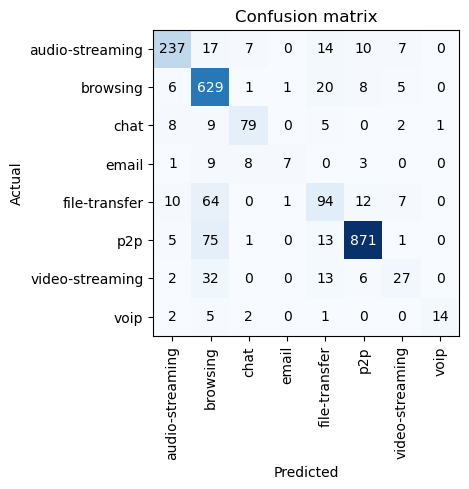

In [35]:
results_sparse_pe_cnn_7 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    SparsePositionalEmbeddingCNN, 
    config = {
        'conv_layers': [
            {
                'filters': 2,
                'filter_width': 4,
                'num_encodings': 256,
                'positional_type': 'fourier_exp',
                'pool_size': 32
            },
        ],
        'fc_layers': [
            100 for _ in range(3)
        ]
    },
    epochs=200
)

Shape of Input Data: (11762, 63)
Parameters in the model: 56490


Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
pre-flatten - torch.Size([64, 8, 32])
post-flatten - torch.Size([64, 256])
Post-run: simple_model - torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,2.049055,2.018947,0.409439,0.124612,0.623754,0.010393,0.072866,0.051486,0.124612,00:40
1,1.903313,1.830438,0.410714,0.125000,0.685707,0.000000,0.072785,0.051339,0.125000,00:41
2,1.682013,1.599570,0.410714,0.125000,0.698931,0.000000,0.072785,0.051339,0.125000,00:40
3,1.523678,1.478313,0.411139,0.125187,0.706849,0.012883,0.073244,0.082677,0.125187,00:40
4,1.440336,1.404560,0.485969,0.159680,0.707797,0.204339,0.126762,0.108890,0.159680,00:40
5,1.370085,1.323897,0.520408,0.176221,0.716178,0.267889,0.143711,0.121995,0.176221,00:40
6,1.284428,1.253564,0.613946,0.260929,0.732046,0.429624,0.250664,0.255259,0.260929,00:40
7,1.233186,1.202521,0.623299,0.269088,0.750089,0.446322,0.251256,0.239980,0.269088,00:46
8,1.173432,1.153991,0.651361,0.288597,0.766393,0.494933,0.268851,0.367985,0.288597,00:40
9,1.165166,1.114146,0.644983,0.289117,0.778621,0.481392,0.278067,0.343326,0.289117,00:41


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


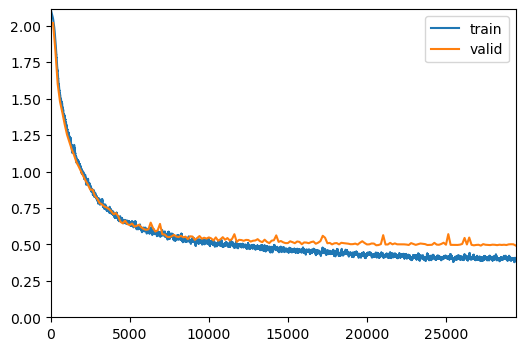

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

loss: 0.49215444922447205, accuracy:  83.76%


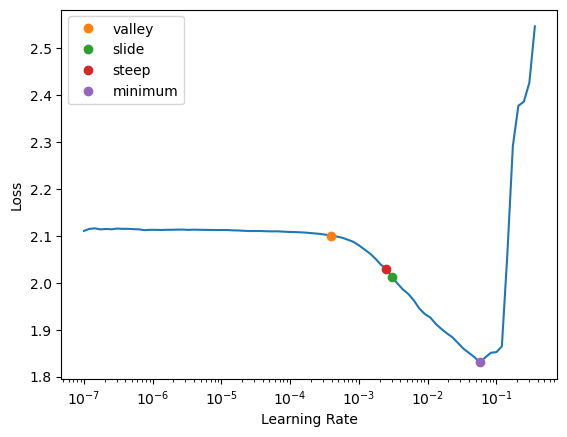

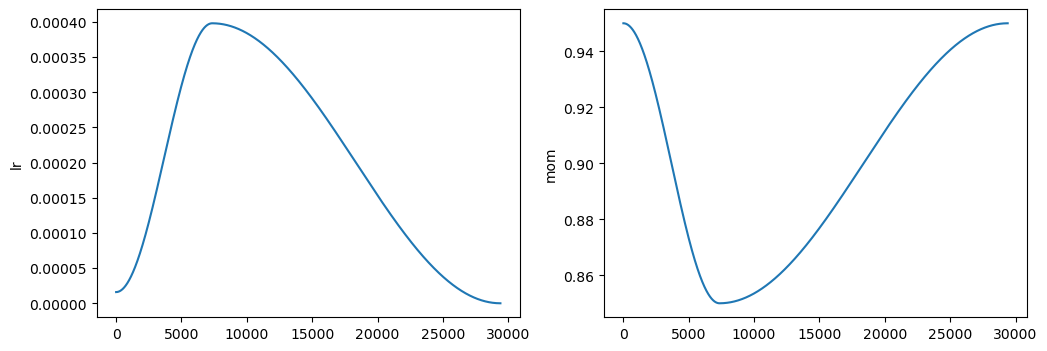

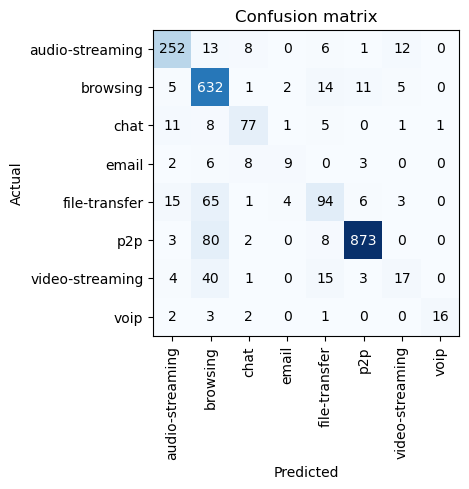

In [36]:
results_sparse_pe_cnn_8 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    SparsePositionalEmbeddingCNN, 
    config = {
        'conv_layers': [
            {
                'filters': 2,
                'filter_width': 4,
                'num_encodings': 512,
                'positional_type': 'fourier_exp',
                'pool_size': 32
            },
        ],
        'fc_layers': [
            100 for _ in range(3)
        ]
    },
    epochs=200
)

Shape of Input Data: (11762, 63)
Parameters in the model: 56490


Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
pre-flatten - torch.Size([64, 8, 32])
post-flatten - torch.Size([64, 256])
Post-run: simple_model - torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.983638,1.911753,0.410714,0.125000,0.645317,0.000000,0.072785,0.051339,0.125000,07:35
1,1.665741,1.553917,0.410714,0.125000,0.696849,0.000000,0.072785,0.051339,0.125000,09:15
2,1.494228,1.427615,0.428571,0.134036,0.710042,0.087872,0.096153,0.079753,0.134036,10:20
3,1.381652,1.323778,0.520833,0.175779,0.717508,0.267982,0.142992,0.121610,0.175779,10:29
4,1.281647,1.239626,0.624575,0.267220,0.743434,0.446299,0.257053,0.261945,0.267220,10:33
5,1.207579,1.175869,0.652211,0.293806,0.758766,0.495830,0.281251,0.368735,0.293806,10:21
6,1.170490,1.134005,0.641582,0.288128,0.784819,0.476751,0.276351,0.322421,0.288128,10:23
7,1.122078,1.086045,0.656463,0.295983,0.798669,0.502601,0.281962,0.329145,0.295983,10:28
8,1.081319,1.048826,0.662840,0.299595,0.805963,0.514906,0.284301,0.311755,0.299595,10:19
9,1.044825,1.026486,0.661139,0.297991,0.816180,0.509269,0.285556,0.331855,0.297991,10:13


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


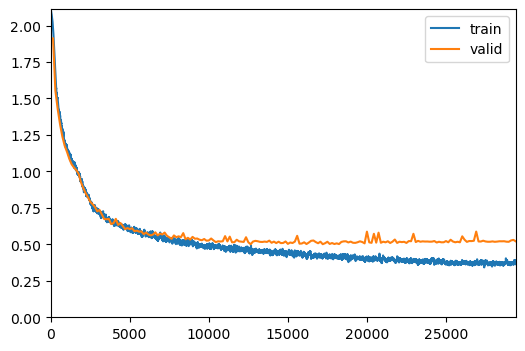

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

loss: 0.5207540988922119, accuracy:  83.76%


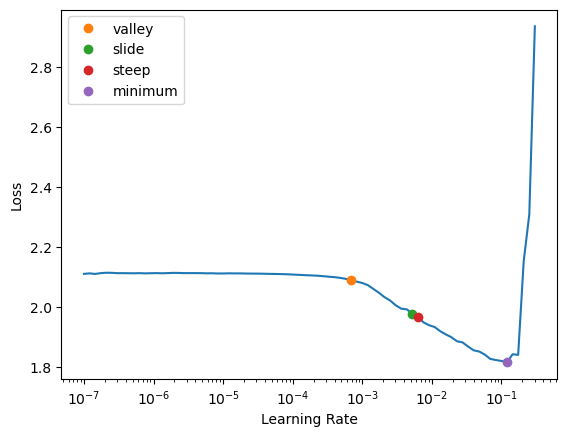

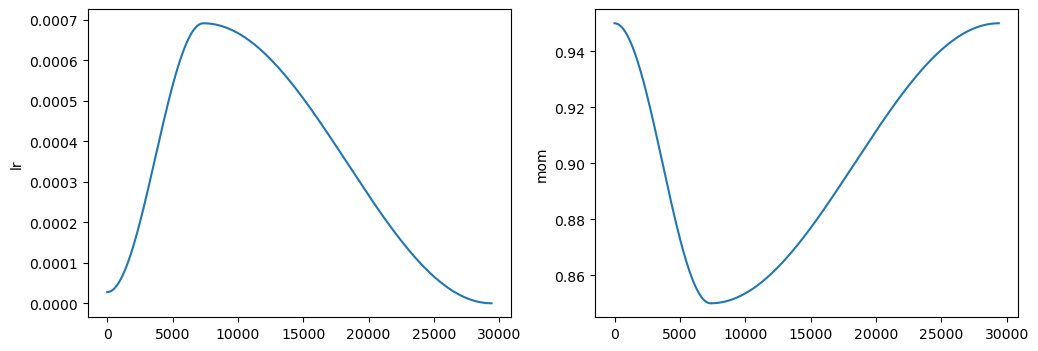

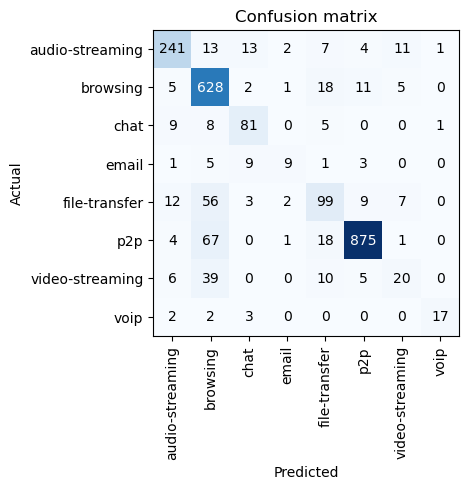

In [37]:
results_sparse_pe_cnn_9 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    SparsePositionalEmbeddingCNN, 
    config = {
        'conv_layers': [
            {
                'filters': 2,
                'filter_width': 4,
                'num_encodings': 1024,
                'positional_type': 'fourier_exp',
                'pool_size': 32
            },
        ],
        'fc_layers': [
            100 for _ in range(3)
        ]
    },
    epochs=200
)